In [8]:
# Import the required libraries and dependencies
import os
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import alpaca_trade_api as tradeapi

plt.style.use('fivethirtyeight')

In [9]:
# Import API keys
load_dotenv()

Python-dotenv could not parse statement starting at line 1


True

In [10]:
# Pull the filtered list of undervalued stocks
undervalued_stocks = pd.read_excel(Path('../value_strat.xlsx'))

In [11]:
# Access the API
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [12]:
# Set the parameters for the alpaca API call
tickers = []
timeframe = "1D"
start_date = pd.Timestamp("2017-02-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2022-02-18", tz="America/New_York").isoformat()

# Set the number of stocks to run the analysis on
num_of_tickers = 3
for i in range(num_of_tickers):
    tickers.append(undervalued_stocks['Ticker'][i])

In [13]:
# Call the API data
ticker_data = alpaca.get_barset(
    tickers, 
    timeframe,
    start = start_date,
    end = end_date,
    limit = 1000
).df

ticker_data.head()

CMCSA                                    INTC  \
                            open    high     low  close    volume   open   
time                                                                       
2018-03-05 00:00:00-05:00  36.17  37.105  35.930  36.79  24608061  48.49   
2018-03-06 00:00:00-05:00  37.08  37.090  36.385  36.86  15495562  50.16   
2018-03-07 00:00:00-05:00  36.82  36.820  36.030  36.12  21028206  50.18   
2018-03-08 00:00:00-05:00  36.37  37.010  36.110  36.89  18610936  51.76   
2018-03-09 00:00:00-05:00  37.00  37.140  36.500  37.13  16658475  51.23   

                                                                WBA         \
                             high     low    close    volume   open   high   
time                                                                         
2018-03-05 00:00:00-05:00  49.795  48.041  49.7500  24227368  70.04  70.67   
2018-03-06 00:00:00-05:00  51.330  50.150  50.7100  32894661  70.55  70.55   
2018-03-07 00:00:00-05:00  51.485  50.100  51.3200  25181632  69.26  70.25   
2018-03-08 00:00:00-05:00  52.080  50.470  50.7300  23778508  69.81  70.16   
2018-03-09 00:00:00-05:00  52.300  51.000  52.1801  25067229  69.20  70.69   

                                                    
                               low  close   volume  
time                                                
2018-03-05 00:00:00-05:00  69.3866  70.54  3518278  
2018-03-06 00:00:00-05:00  68.8200  69.79  3458965  
2018-03-07 00:00:00-05:00  68.9800  69.51  3016250  
2018-03-08 00:00:00-05:00  68.5000  68.96  3632886  
2018-03-09 00:00:00-05:00  68.5750  70.60  2752617

In [14]:
#Create a list of DataFrames for each stock
stock_dfs = []

for ticker in tickers:
    vars()[ticker] = pd.DataFrame(ticker_data[ticker])
    stock_dfs.append(vars()[ticker])

In [15]:
#Visualize the list of DataFrames
stock_dfs

[                            open    high     low  close    volume
 time                                                             
 2018-03-05 00:00:00-05:00  36.17  37.105  35.930  36.79  24608061
 2018-03-06 00:00:00-05:00  37.08  37.090  36.385  36.86  15495562
 2018-03-07 00:00:00-05:00  36.82  36.820  36.030  36.12  21028206
 2018-03-08 00:00:00-05:00  36.37  37.010  36.110  36.89  18610936
 2018-03-09 00:00:00-05:00  37.00  37.140  36.500  37.13  16658475
 ...                          ...     ...     ...    ...       ...
 2022-02-14 00:00:00-05:00  47.78  48.390  47.070  47.40  18173302
 2022-02-15 00:00:00-05:00  47.71  48.315  47.690  48.05  14944262
 2022-02-16 00:00:00-05:00  47.91  48.255  47.650  48.07  12004639
 2022-02-17 00:00:00-05:00  47.63  47.660  46.670  46.78  15383531
 2022-02-18 00:00:00-05:00  46.80  47.150  46.430  46.63  16632635
 
 [1000 rows x 5 columns],
                             open     high      low    close    volume
 time                         

In [16]:
#Calculate the exponential moving averages of the selected stock
for stock in stock_dfs:
    stock['return'] = stock['close'].pct_change()
    stock['cumulative_return'] = (stock['return'] + 1).cumprod() - 1    
    stock['2_dayma'] = stock['close'].ewm(span=2, adjust = False).mean()
    stock['3_dayma'] = stock['close'].ewm(span=3, adjust = False).mean()
    stock['5_dayma'] = stock['close'].ewm(span=5, adjust = False).mean()
    stock['8_dayma'] = stock['close'].ewm(span=8, adjust = False).mean()
    stock['13_dayma'] = stock['close'].ewm(span=13, adjust = False).mean()
    stock['21_dayma'] = stock['close'].ewm(span=21, adjust = False).mean()
    stock['34_dayma'] = stock['close'].ewm(span=34, adjust = False).mean()
    stock['55_dayma'] = stock['close'].ewm(span=55, adjust = False).mean()

    stock = stock.dropna(inplace=True)

In [17]:
# Set the conditions for when you will enter the position
for stock in stock_dfs:
    stock['strat1_return'] = np.where(((stock['close'] > stock['2_dayma']) & (stock['close'] > stock['3_dayma'])) | ((stock['close'] < stock['2_dayma']) & (stock['close'] < stock['3_dayma'])), stock['return'], 0)
    stock['strat2_return'] = np.where(((stock['2_dayma'] > stock['3_dayma']) & (stock['2_dayma'] > stock['5_dayma'])) | ((stock['2_dayma'] < stock['3_dayma']) & (stock['2_dayma'] < stock['5_dayma'])), stock['return'], 0)
    stock['strat3_return'] = np.where(((stock['3_dayma'] > stock['5_dayma']) & (stock['3_dayma'] > stock['8_dayma'])) | ((stock['3_dayma'] < stock['5_dayma']) & (stock['3_dayma'] < stock['8_dayma'])), stock['return'], 0)
    stock['strat4_return'] = np.where(((stock['5_dayma'] > stock['8_dayma']) & (stock['5_dayma'] > stock['13_dayma'])) | ((stock['5_dayma'] < stock['8_dayma']) & (stock['5_dayma'] < stock['13_dayma'])), stock['return'], 0)
    stock['strat5_return'] = np.where(((stock['8_dayma'] > stock['13_dayma']) & (stock['8_dayma'] > stock['21_dayma'])) | ((stock['8_dayma'] < stock['13_dayma']) & (stock['8_dayma'] < stock['21_dayma'])), stock['return'], 0)
    stock['strat6_return'] = np.where(((stock['13_dayma'] > stock['21_dayma']) & (stock['13_dayma'] > stock['34_dayma'])) | ((stock['13_dayma'] < stock['21_dayma']) & (stock['13_dayma'] < stock['34_dayma'])), stock['return'], 0)
    stock['strat7_return'] = np.where(((stock['21_dayma'] > stock['34_dayma']) & (stock['21_dayma'] > stock['55_dayma'])) | ((stock['21_dayma'] < stock['34_dayma']) & (stock['21_dayma'] < stock['55_dayma'])), stock['return'], 0)

In [18]:
#Calculate the cumulative return of each strategy
for stock in stock_dfs:
    stock['strat1_cum_return'] = (stock['strat1_return'] + 1).cumprod() - 1
    stock['strat2_cum_return'] = (stock['strat2_return'] + 1).cumprod() - 1
    stock['strat3_cum_return'] = (stock['strat3_return'] + 1).cumprod() - 1
    stock['strat4_cum_return'] = (stock['strat4_return'] + 1).cumprod() - 1
    stock['strat5_cum_return'] = (stock['strat5_return'] + 1).cumprod() - 1
    stock['strat6_cum_return'] = (stock['strat6_return'] + 1).cumprod() - 1
    stock['strat7_cum_return'] = (stock['strat7_return'] + 1).cumprod() - 1

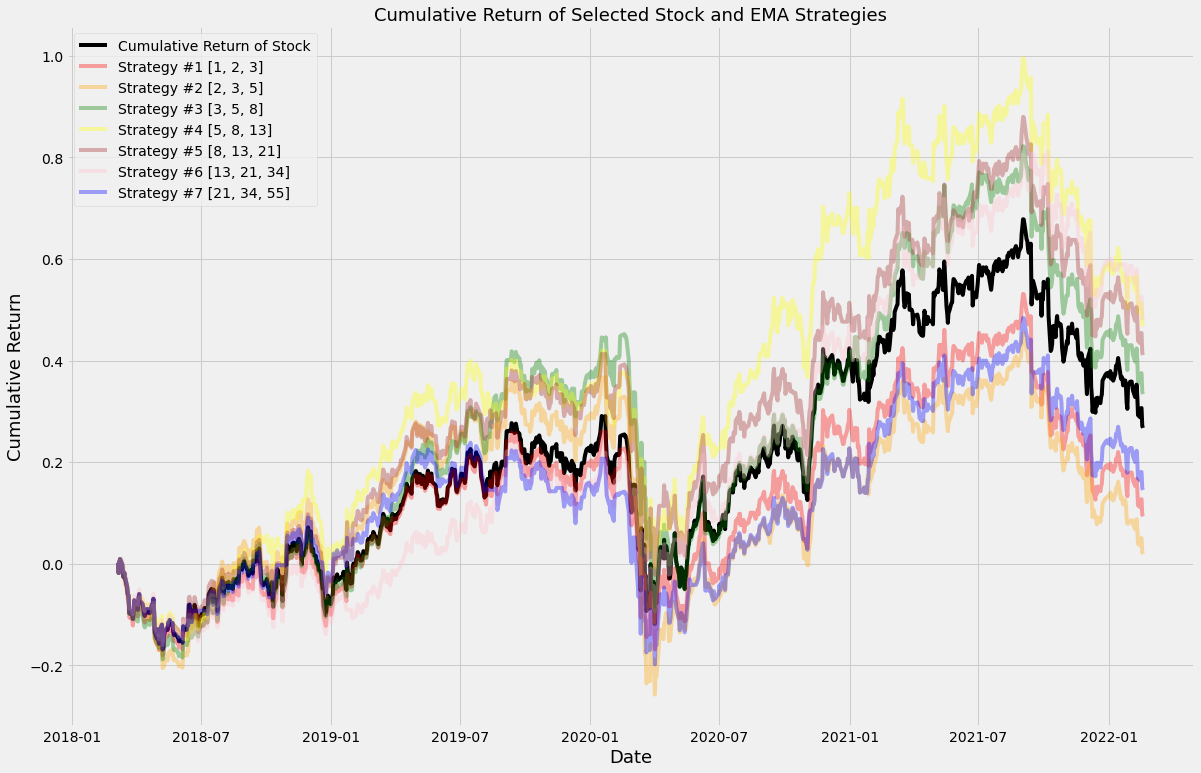

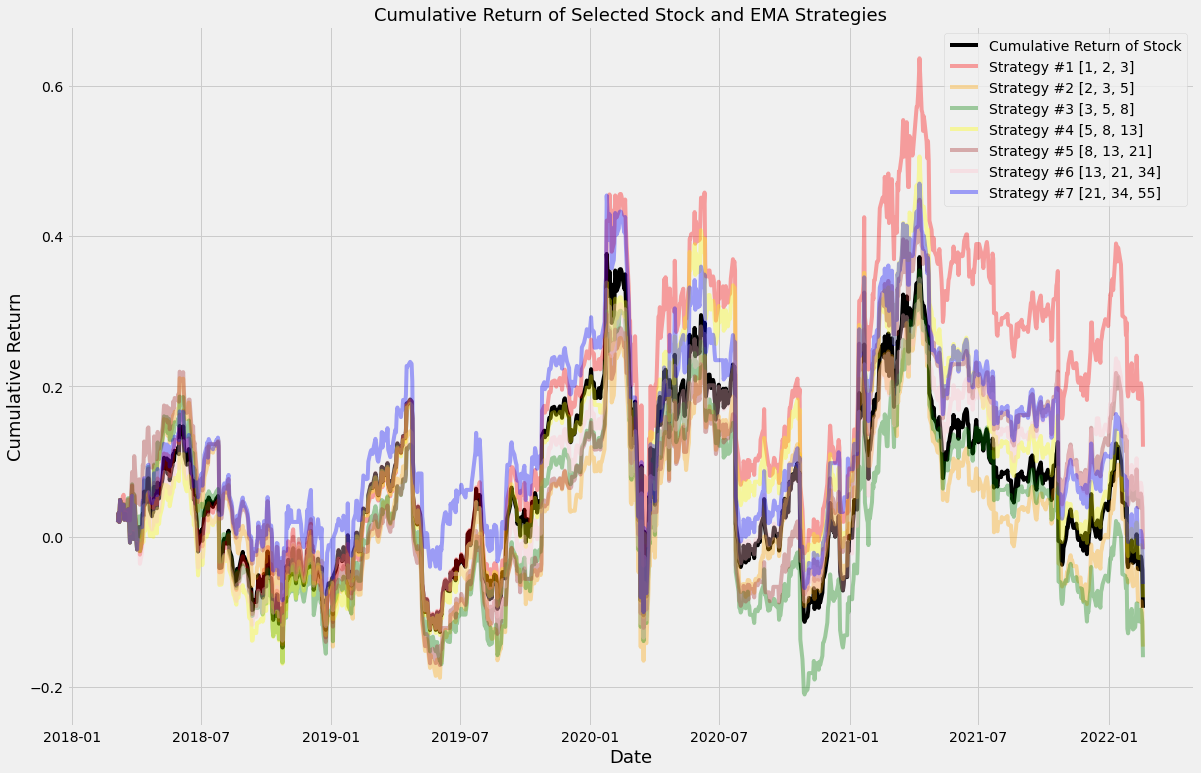

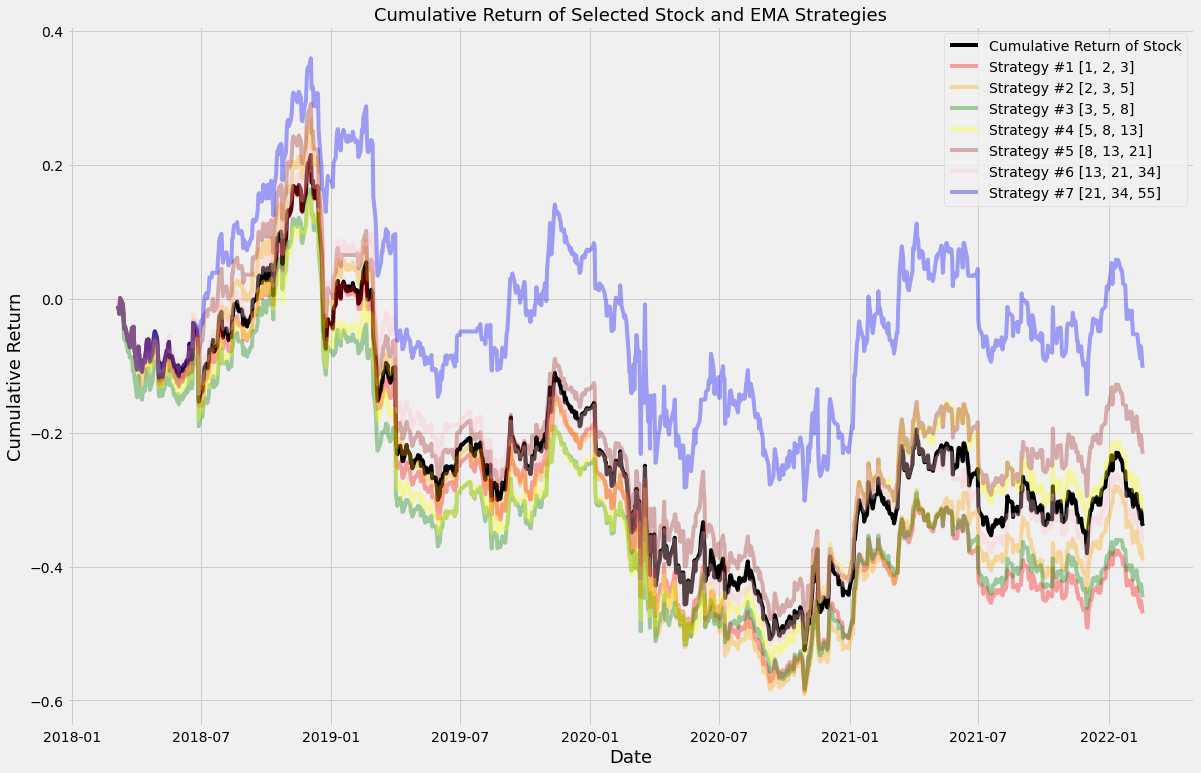

In [19]:
#Visualize the Moving Averages
for stock in stock_dfs:
    plt.figure(figsize = (18, 12))
    plt.title(f'Cumulative Return of Selected Stock and EMA Strategies', fontsize=18)
    plt.xlabel('Date', fontsize = 18)
    plt.ylabel('Cumulative Return', fontsize = 18)

    plt.plot(stock['cumulative_return'], label = 'Cumulative Return of Stock', color = 'black', alpha = 1)
    plt.plot(stock['strat1_cum_return'], label = 'Strategy #1 [1, 2, 3]', color = 'red', alpha = 0.35)
    plt.plot(stock['strat2_cum_return'], label = 'Strategy #2 [2, 3, 5]', color = 'orange', alpha = 0.35)
    plt.plot(stock['strat3_cum_return'], label = 'Strategy #3 [3, 5, 8]', color = 'green', alpha = 0.35)
    plt.plot(stock['strat4_cum_return'], label = 'Strategy #4 [5, 8, 13]', color = 'yellow', alpha = 0.35)
    plt.plot(stock['strat5_cum_return'], label = 'Strategy #5 [8, 13, 21]', color = 'brown', alpha = 0.35)
    plt.plot(stock['strat6_cum_return'], label = 'Strategy #6 [13, 21, 34]', color = 'pink', alpha = 0.35)
    plt.plot(stock['strat7_cum_return'], label = 'Strategy #7 [21, 34, 55]', color = 'blue', alpha = 0.35)

    plt.legend()
    plt.show()

In [20]:
# Calculate the mean cumulative return of the stocks and the strategies across stocks

summary_df = pd.concat(stock_dfs, axis=1)

summary_df['mean_all_stocks_cumulative_returns'] = summary_df['cumulative_return'].mean(axis=1)
summary_df['strat1_analysis'] = summary_df['strat1_cum_return'].mean(axis=1)
summary_df['strat2_analysis'] = summary_df['strat2_cum_return'].mean(axis=1)
summary_df['strat3_analysis'] = summary_df['strat3_cum_return'].mean(axis=1)
summary_df['strat4_analysis'] = summary_df['strat4_cum_return'].mean(axis=1)
summary_df['strat5_analysis'] = summary_df['strat5_cum_return'].mean(axis=1)
summary_df['strat6_analysis'] = summary_df['strat6_cum_return'].mean(axis=1)
summary_df['strat7_analysis'] = summary_df['strat7_cum_return'].mean(axis=1)

summary_df.dropna(inplace=True)
summary_df

,open,high,low,close,volume,return,cumulative_return,2_dayma,3_dayma,5_dayma,...,strat6_cum_return,strat7_cum_return,mean_all_stocks_cumulative_returns,strat1_analysis,strat2_analysis,strat3_analysis,strat4_analysis,strat5_analysis,strat6_analysis,strat7_analysis
time,,,,,,,,,,,,,,,,,,,,,
2018-03-06 00:00:00-05:00,37.08,37.090,36.385,36.86,15495562,0.001903,0.001903,36.836667,36.825000,36.813333,...,-0.010632,-0.010632,0.003522,0.003522,0.003522,0.003522,0.003522,0.003522,0.003522,0.003522
2018-03-07 00:00:00-05:00,36.82,36.820,36.030,36.12,21028206,-0.020076,-0.018211,36.358889,36.472500,36.582222,...,-0.014602,-0.014602,-0.000418,-0.000418,-0.000418,-0.000418,-0.000418,-0.000418,-0.000418,-0.000418
2018-03-08 00:00:00-05:00,36.37,37.010,36.110,36.89,18610936,0.021318,0.002718,36.712963,36.681250,36.684815,...,-0.022399,-0.022399,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006
2018-03-09 00:00:00-05:00,37.00,37.140,36.500,37.13,16658475,0.006506,0.009242,36.990988,36.905625,36.833210,...,0.000851,0.000851,0.019646,0.019646,0.019646,0.011896,0.019646,0.019646,0.019646,0.019646
2018-03-12 00:00:00-04:00,37.09,37.215,36.660,36.75,13085914,-0.010234,-0.001087,36.830329,36.827813,36.805473,...,-0.005529,-0.005529,0.009721,0.014077,0.009721,0.004098,0.009721,0.009721,0.013164,0.009721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-14 00:00:00-05:00,47.78,48.390,47.070,47.40,18173302,-0.003364,0.288394,47.628153,47.890002,48.268048,...,-0.354009,-0.088784,-0.027877,-0.055618,-0.143667,-0.064568,0.052496,0.084641,0.067763,0.021836
2022-02-15 00:00:00-05:00,47.71,48.315,47.690,48.05,14944262,0.013713,0.306061,47.909384,47.970001,48.195365,...,-0.341323,-0.070890,-0.011898,-0.039969,-0.134879,-0.049401,0.069643,0.102493,0.085137,0.039017
2022-02-16 00:00:00-05:00,47.91,48.255,47.650,48.07,12004639,0.000416,0.306605,48.016461,48.020001,48.153577,...,-0.346780,-0.078586,-0.015081,-0.043152,-0.136476,-0.052163,0.066400,0.098895,0.081907,0.035090


In [21]:
# Create a new DataFrame of the aggregate analysis 
ma_analysis = summary_df[['mean_all_stocks_cumulative_returns','strat1_analysis', 'strat2_analysis', 'strat3_analysis', 'strat4_analysis', 'strat5_analysis', 'strat6_analysis', 'strat7_analysis']] 

ma_analysis

,mean_all_stocks_cumulative_returns,strat1_analysis,strat2_analysis,strat3_analysis,strat4_analysis,strat5_analysis,strat6_analysis,strat7_analysis
time,,,,,,,,
2018-03-06 00:00:00-05:00,0.003522,0.003522,0.003522,0.003522,0.003522,0.003522,0.003522,0.003522
2018-03-07 00:00:00-05:00,-0.000418,-0.000418,-0.000418,-0.000418,-0.000418,-0.000418,-0.000418,-0.000418
2018-03-08 00:00:00-05:00,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006
2018-03-09 00:00:00-05:00,0.019646,0.019646,0.019646,0.011896,0.019646,0.019646,0.019646,0.019646
2018-03-12 00:00:00-04:00,0.009721,0.014077,0.009721,0.004098,0.009721,0.009721,0.013164,0.009721
...,...,...,...,...,...,...,...,...
2022-02-14 00:00:00-05:00,-0.027877,-0.055618,-0.143667,-0.064568,0.052496,0.084641,0.067763,0.021836
2022-02-15 00:00:00-05:00,-0.011898,-0.039969,-0.134879,-0.049401,0.069643,0.102493,0.085137,0.039017
2022-02-16 00:00:00-05:00,-0.015081,-0.043152,-0.136476,-0.052163,0.066400,0.098895,0.081907,0.035090


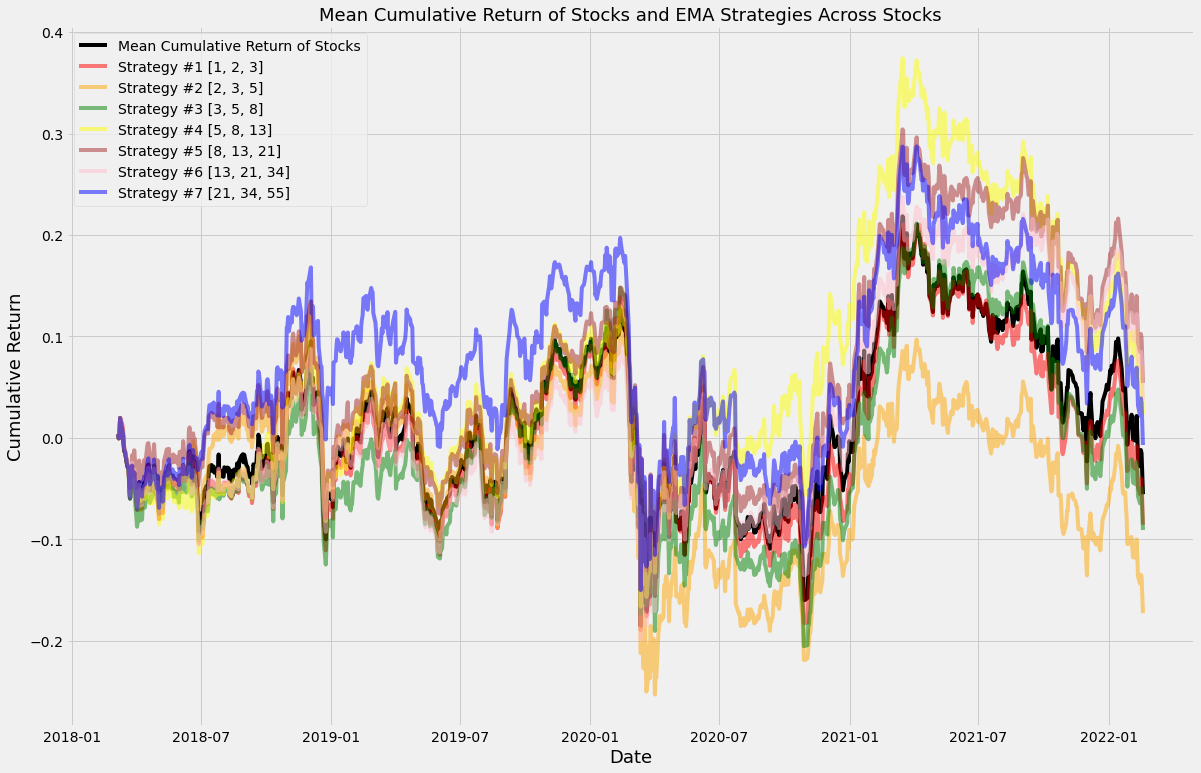

In [22]:
plt.figure(figsize = (18, 12))
plt.title('Mean Cumulative Return of Stocks and EMA Strategies Across Stocks', fontsize=18)
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Cumulative Return', fontsize = 18)

plt.plot(ma_analysis['mean_all_stocks_cumulative_returns'], label = 'Mean Cumulative Return of Stocks', color = 'black', alpha = 1)
plt.plot(ma_analysis['strat1_analysis'], label = 'Strategy #1 [1, 2, 3]', color = 'red', alpha = 0.5)
plt.plot(ma_analysis['strat2_analysis'], label = 'Strategy #2 [2, 3, 5]', color = 'orange', alpha = 0.5)
plt.plot(ma_analysis['strat3_analysis'], label = 'Strategy #3 [3, 5, 8]', color = 'green', alpha = 0.5)
plt.plot(ma_analysis['strat4_analysis'], label = 'Strategy #4 [5, 8, 13]', color = 'yellow', alpha = 0.5)
plt.plot(ma_analysis['strat5_analysis'], label = 'Strategy #5 [8, 13, 21]', color = 'brown', alpha = 0.5)
plt.plot(ma_analysis['strat6_analysis'], label = 'Strategy #6 [13, 21, 34]', color = 'pink', alpha = 0.5)
plt.plot(ma_analysis['strat7_analysis'], label = 'Strategy #7 [21, 34, 55]', color = 'blue', alpha = 0.5)

plt.legend()
plt.show()

In [23]:
ma_analysis.tail()

,mean_all_stocks_cumulative_returns,strat1_analysis,strat2_analysis,strat3_analysis,strat4_analysis,strat5_analysis,strat6_analysis,strat7_analysis
time,,,,,,,,
2022-02-14 00:00:00-05:00,-0.027877,-0.055618,-0.143667,-0.064568,0.052496,0.084641,0.067763,0.021836
2022-02-15 00:00:00-05:00,-0.011898,-0.039969,-0.134879,-0.049401,0.069643,0.102493,0.085137,0.039017
2022-02-16 00:00:00-05:00,-0.015081,-0.043152,-0.136476,-0.052163,0.066400,0.098895,0.081907,0.035090
2022-02-17 00:00:00-05:00,-0.036204,-0.062696,-0.154665,-0.072764,0.043192,0.075247,0.058578,0.013126
2022-02-18 00:00:00-05:00,-0.055483,-0.085611,-0.172635,-0.090727,0.023404,0.054197,0.037400,-0.006960
